First thing that will be done is a 2 class classification of ratings with words and extra features. Another iteration without extra features and just vectorized words. After that, back to the original 5 classes for ratings with and without extra features. If time permits, the best model will be ran again but just for brands and types of shoes.

Uncomment and run the cell below if running on google cloud

In [509]:
# %cd Amazon-Reviews-Capstone

In [50]:
# importing library for loading
import pandas as pd
# pickle for faster loading of file
import pickle
# os to check files and paths
import os

In [2]:
%%time

# check if the pkl file of the dataframe exists 
if (os.path.isfile('shoes.pkl')):
    # load if it exists
    with open('shoes.pkl', 'rb') as f:
        df = pickle.load(f)
else:
    # if it doesn't exist, load the tsv into df and save into pkl file for future use
    file_path = 'Shoes.tsv'
    df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')
    
    # Uncomment code below for when using google cloud
    # bucket_name = 'amazon_shoes_review'
    # file_path = 'gs://amazon_shoes_review/Shoes.tsv'

    with open('shoes.pkl', 'wb') as f:
        pickle.dump(df, f)

CPU times: total: 5.89 s
Wall time: 6.65 s


## Data Prep

In [3]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,108364,R2NZXYIVCGB13W,B00XFBPOQG,448483263,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,45449350,R2EQ1TG9IT3OEQ,B00SW64Y9W,7853171,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31


In [4]:
df.shape

(4358820, 15)

There are 4358820 rows and 15 columns to the dataset. 

Next, drop columns that are unnecessary to this report (customer_id, review_id, product_id, product_parent, vine). There are other columns that could be dropped as they don't add to the main model but it will be kept for now for maybe help further gain insight.

In [5]:
df.drop(columns=['customer_id', 'review_id', 'product_id', 'product_parent', 'product_category', 'vine'], inplace=True)

In [6]:
# Sanity Check
df

,marketplace,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,US,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,Teva Men's Pajaro Flip-Flop,5,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,Anne Klein Perfect Pair Wristlet,4,0,0,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,Y,Badass,Getting what u see,2015-08-31
4,US,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,Y,Three Stars,small,2015-08-31
...,...,...,...,...,...,...,...,...,...
4358815,US,Fox Men's Featherlite Shoe Lace-Up,4,1,6,N,Get it All,If you are a fan of &quot;extreme sports&quot;...,2000-04-07
4358816,US,Floor Spinner,1,5,5,N,Looks can be deceiving,This toy has gotten rave reviews from adults b...,2000-01-27
4358817,US,Floor Spinner,4,7,7,N,My seven month old loves this toy!,My seven month old son loves to watch me shake...,1999-12-03
4358818,US,Floor Spinner,5,3,3,N,What a wonderful toy!,All three of my children have enjoyed watching...,1999-12-01


In [7]:
df['marketplace'].value_counts()

US    4358820
Name: marketplace, dtype: int64

Theres only 1 value for marketplace so this column can be dropped as well. 

In [8]:
df.drop(columns='marketplace', inplace=True)

In [9]:
# sanity check
df.head()

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,Teva Men's Pajaro Flip-Flop,5,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,Anne Klein Perfect Pair Wristlet,4,0,0,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,Y,Badass,Getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,Y,Three Stars,small,2015-08-31


In [10]:
for column in df.columns:
    print(df[column].value_counts())

Skechers Performance Women's Go Walk Slip-On Walking Shoe                               5966
Sanuk Women's Yoga Sling 2 Flip Flop                                                    5339
TOMS Women's Classics Flat                                                              4275
Crocs Unisex Classic Clog                                                               4014
Clarks Women's Breeze Sea Flip-Flop                                                     3864
                                                                                        ... 
Orla Kiely Stem Quilted Backpack                                                           1
FLY London Women's Gabe Wedge Pump                                                         1
Nike Air Vortex Vintage Mens Running Shoes 429773-680                                      1
Fancasen Fashion Women Lady Satchel Canvas Tote Handbag Shoulder Messenger Hobo Bags       1
HI-TEC Courmayeur Ladies Winter Boot, Black, US7.5                    

In [11]:
# Check for nulls
df.isna().sum()

product_title          1
star_rating            0
helpful_votes          0
total_votes            0
verified_purchase      0
review_headline       26
review_body          440
review_date           21
dtype: int64

In [12]:
(df.isna().sum())/df.shape[0]

product_title        2.294199e-07
star_rating          0.000000e+00
helpful_votes        0.000000e+00
total_votes          0.000000e+00
verified_purchase    0.000000e+00
review_headline      5.964917e-06
review_body          1.009448e-04
review_date          4.817818e-06
dtype: float64

Since the null values are significantly smaller than the dataset, it is fine to just drop those rows that have null values.

In [13]:
# Dropping the nulls
df = df.dropna()

In [14]:
# check for duplicates
df.duplicated().sum()

563

Luckily, there are no duplicates in this dataset

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [16]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['product_title']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

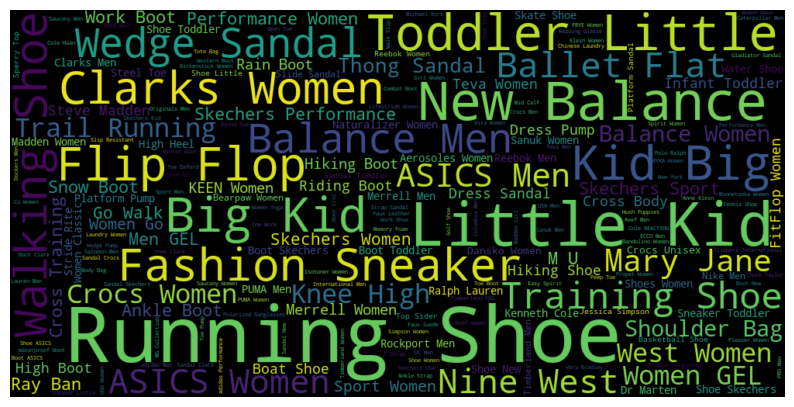

In [17]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
# Extract word frequencies from the word cloud
word_frequencies = wordcloud.words_
word_frequencies

{'Running Shoe': 1.0,
 'Little Kid': 0.5577493201752891,
 'New Balance': 0.4338985476626979,
 'Toddler Little': 0.3686149295640262,
 'Big Kid': 0.3505816846022259,
 'Kid Big': 0.33399668777133357,
 'Flip Flop': 0.3285001601592051,
 'Walking Shoe': 0.3056110244055367,
 'Fashion Sneaker': 0.3011265666637134,
 'Clarks Women': 0.29606962495484873,
 'Balance Men': 0.23766944503131623,
 'Wedge Sandal': 0.23401645209876712,
 'Training Shoe': 0.20339196750471958,
 'Ballet Flat': 0.19417770174948373,
 'ASICS Women': 0.1813070354190378,
 'Nine West': 0.17970885101104758,
 'ASICS Men': 0.17186786524817863,
 'Mary Jane': 0.1619618480327679,
 'Trail Running': 0.15870073400622917,
 'Crocs Women': 0.1580157978313762,
 'West Women': 0.15533739069986166,
 'Women GEL': 0.15493188122320742,
 'Knee High': 0.15435598961350516,
 'Shoulder Bag': 0.14987834715700374,
 'Balance Women': 0.14780650041914004,
 'Thong Sandal': 0.14604474916342372,
 'Skechers Sport': 0.14396267949757716,
 'Skechers Performance': 0.

It can be observed in the word cloud that the dataset does include shoes (with great vareity from flip flops to sneakers to boots) but also includes items that aren't shoes such as 'ray ban' and 'shoulder bag' and many more. To remove these non-shoe products, it will be manually removed if a certain keyword is in the product title so any products, for example, with `sunglasses` in the name will be searched for and removed. The list of words can be found in `common_others` variable which are the list of words that will be searched and remove the row if the product title contains any of these words.  

In [16]:
# removing products that are in no way related to shoes
common_others = [r'\bbag(s)?\b', 'sunglasses', 'wallet', r'ray[- ]?ban', 'tote', 'handbag', 'purse', 'clutch', 'spinner', 'wrist'] 
label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)
df_others=df[label_others]

C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\2274891717.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)


In [17]:
df_others

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
2,Anne Klein Perfect Pair Wristlet,4,0,0,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
14,Travel Smart Hand Pouch Bag In Bag Organiser C...,2,1,2,Y,Two Stars,It's okay .,2015-08-31
22,Studded Flat Top Sunglasses Bold Square DG Fas...,5,0,0,Y,Five Stars,Absolutely love!!,2015-08-31
23,Baggallini Town Tote -Giraffe Printed,5,0,0,Y,Never travel without it!!,Very sturdy. A great travel tote - lots of poc...,2015-08-31
36,Relic Caraway Double Shoulder Bag,5,2,2,Y,I have not used it yet but it is brand new and...,It is larger than I anticipated. I have not u...,2015-08-31
...,...,...,...,...,...,...,...,...
4358814,Floor Spinner,2,0,0,N,This toy is not a must have,This toy looks like more fun than it really is...,2001-04-02
4358816,Floor Spinner,1,5,5,N,Looks can be deceiving,This toy has gotten rave reviews from adults b...,2000-01-27
4358817,Floor Spinner,4,7,7,N,My seven month old loves this toy!,My seven month old son loves to watch me shake...,1999-12-03
4358818,Floor Spinner,5,3,3,N,What a wonderful toy!,All three of my children have enjoyed watching...,1999-12-01


In [18]:
# removing the products from the dataframe
df = df[~label_others]

In [19]:
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,Teva Men's Pajaro Flip-Flop,5,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,Y,Badass,Getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,Y,Three Stars,small,2015-08-31
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,Y,Five Stars,My 13 year old son loved these shoes excellent...,2015-08-31
...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,N,What a waste,"I purchased this shoe because it looked good, ...",2002-10-30
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,N,You want it! You need it!,This little shoe-boot is so great if you're th...,2002-10-16
4358812,Women's CanvasMule Shoes,5,0,0,N,Cute,"The backless mule is very comfortable , cute ,...",2002-09-02
4358813,Birki's Super Birki Unisex Clog,5,10,11,N,Graceless and Immense - Comfy and Cool,"My garden clogs make my feet look huge, and ev...",2002-03-24


In [20]:
# removing products that are close to shoes but aren't 
common_others2 = ['polish', 'laces'] 
label_others2 = df['product_title'].str.contains('|'.join(common_others2), case=False, na=False)
df_others=df[label_others2]

In [21]:
# pd.set_option('display.max_colwidth', None)
df_others['product_title']

807        Round Shoelaces 3/16" Thick Solid Colors for A...
1392       LOCK LACES (Elastic No Tie Shoe Laces) (Pack o...
1399                        HICKIES Elastic No Tie Shoelaces
1525                       Kiwi Navy Shoe Polish, 1 - 1/8 oz
1764       Round Shoelaces 3/16" Thick Solid Colors for A...
                                 ...                        
4348484       Leather Shoelaces for Shoe or Boot 45" (Brown)
4349082                  Punisher - Diamond Skulls Shoelaces
4350020                                     Lock Laces(gray)
4353290            Flat Shoe Laces 45 inch, 54 inch, 63 inch
4357149                                   Boot Laces (16212)
Name: product_title, Length: 14501, dtype: object

In [22]:
df = df[~label_others2]

In [23]:
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,Teva Men's Pajaro Flip-Flop,5,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,Y,Badass,Getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,Y,Three Stars,small,2015-08-31
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,Y,Five Stars,My 13 year old son loved these shoes excellent...,2015-08-31
...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,N,What a waste,"I purchased this shoe because it looked good, ...",2002-10-30
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,N,You want it! You need it!,This little shoe-boot is so great if you're th...,2002-10-16
4358812,Women's CanvasMule Shoes,5,0,0,N,Cute,"The backless mule is very comfortable , cute ,...",2002-09-02
4358813,Birki's Super Birki Unisex Clog,5,10,11,N,Graceless and Immense - Comfy and Cool,"My garden clogs make my feet look huge, and ev...",2002-03-24


We have removed 512747 rows of non-shoe data which is around ~11% of the data which may have caused problems if it was left in.

In [23]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['product_title']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

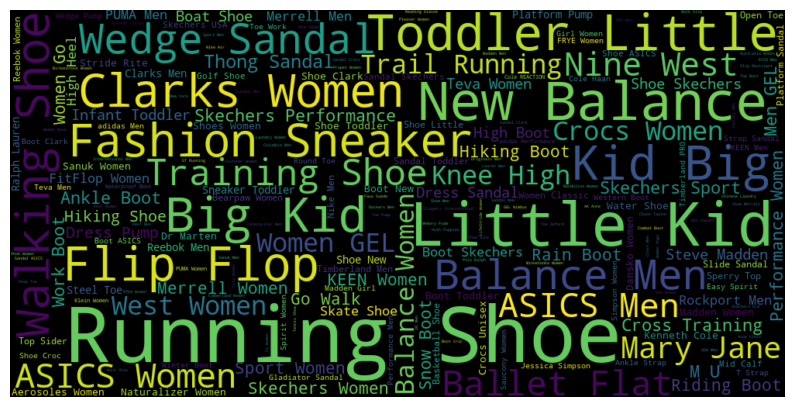

In [24]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
wordcloud.words_

{'Running Shoe': 1.0,
 'Little Kid': 0.5575427523736173,
 'New Balance': 0.4333103866627589,
 'Toddler Little': 0.3684883142376139,
 'Big Kid': 0.35045018641329906,
 'Kid Big': 0.3336355023616895,
 'Flip Flop': 0.32821009153676806,
 'Walking Shoe': 0.3054281371620194,
 'Fashion Sneaker': 0.3010285106702018,
 'Clarks Women': 0.2960597613091871,
 'Balance Men': 0.2375287117375628,
 'Wedge Sandal': 0.23397084182473743,
 'Training Shoe': 0.2034086029567126,
 'Ballet Flat': 0.1926293476556909,
 'ASICS Women': 0.1813218645419413,
 'ASICS Men': 0.17188192234028776,
 'Nine West': 0.1627248376125466,
 'Mary Jane': 0.16195464738237558,
 'Trail Running': 0.15871371415718696,
 'Crocs Women': 0.15802872196132692,
 'West Women': 0.1549684085688775,
 'Women GEL': 0.15494455311927044,
 'Knee High': 0.15390172917930436,
 'Balance Women': 0.14780495784401262,
 'Thong Sandal': 0.14605669417995187,
 'Skechers Sport': 0.1439744542213922,
 'Skechers Performance': 0.14365410961238304,
 'Cross Training': 0.14

From looking at the word cloud of the top 200 most frequent word in the dataframe, the words seems to be shoes or brands related to shoes so there doesn't seem to be any non-shoe data that stands out (and if there is, it won't be too significant as it isn't in the top 200 words)

Now that the non-words have been cleaned and filtered out. The `review_headline` and `review_body` can be further analysed and cleaned if needed. To perform NLP, punctuations and special characters will be needed to be filtered out and this can be done by only looking for letters and numbers (and spaces). Then, the letters should all be converted to lower case. 

In [24]:
df[df['review_body'].str.contains(r'^[A-Za-z0-9 ]*$')]

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
1,Teva Men's Pajaro Flip-Flop,5,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,Y,Badass,Getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,Y,Three Stars,small,2015-08-31
16,Dr. Marten's Women's 1460 Black Patent Lamper ...,5,0,0,Y,Five Stars,Good,2015-08-31
20,RYKA Women's Vida RZX Cross-Training Shoe,4,0,0,Y,Fit small,Had to return for next size Next size was com...,2015-08-31
...,...,...,...,...,...,...,...,...
4357924,adidas Men's The Hood,3,0,1,N,The hood,Well when first putting these shoes on i felt ...,2003-07-10
4358168,Reebok Men's Gridiron Mid,4,19,25,N,nice ...,these shoes r really nice and commfortable for...,2003-04-06
4358315,Nike Men's Air Pippen V,5,0,2,N,perfect,this is the most attractive shoe i have ever s...,2003-02-17
4358524,Timberland Women's Nellie Chukka,5,2,7,N,best boot,i like the boot verry much i cant work in them,2002-12-12


A lot of the reviews have punctuation and special characters which need to be cleaned before vectorizing is done.

In [25]:
# Since the only characters needed are a-z and 0-9, everything else will be replaced with spaces
df['review_body'] = df.loc[:,'review_body'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()

C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\3122726870.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_body'] = df.loc[:,'review_body'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()
C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\3122726870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_body'] = df.loc[:,'review_body'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()


In [26]:
df['review_body']

0          do not buy  really didn t start to wear them u...
1              provides great cushion as well as archsupport
3                                         getting what u see
4                                                      small
5          my 13 year old son loved these shoes excellent...
                                 ...                        
4358810    i purchased this shoe because it looked good  ...
4358811    this little shoe boot is so great if you re th...
4358812    the backless mule is very comfortable   cute  ...
4358813    my garden clogs make my feet look huge  and ev...
4358815    if you are a fan of  quot extreme sports quot ...
Name: review_body, Length: 3846073, dtype: object

In [27]:
# sanity check
df[~df['review_body'].str.contains(r'^[A-Za-z0-9 ]*$')]

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date


The same will be applied to `review_headline`

In [28]:
# Since the only characters needed are a-z and 0-9, everything else will be replaced with spaces
df['review_headline'] = df.loc[:,'review_headline'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()

C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\1363393966.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_headline'] = df.loc[:,'review_headline'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()
C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\1363393966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_headline'] = df.loc[:,'review_headline'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()


In [29]:
# sanity check
df[~df['review_headline'].str.contains(r'^[A-Za-z0-9 ]*$')]

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date


In [30]:
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,Y,,do not buy really didn t start to wear them u...,2015-08-31
1,Teva Men's Pajaro Flip-Flop,5,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,Y,badass,getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,Y,three stars,small,2015-08-31
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,Y,five stars,my 13 year old son loved these shoes excellent...,2015-08-31
...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,N,what a waste,i purchased this shoe because it looked good ...,2002-10-30
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,N,you want it you need it,this little shoe boot is so great if you re th...,2002-10-16
4358812,Women's CanvasMule Shoes,5,0,0,N,cute,the backless mule is very comfortable cute ...,2002-09-02
4358813,Birki's Super Birki Unisex Clog,5,10,11,N,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002-03-24


In [61]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['review_body']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

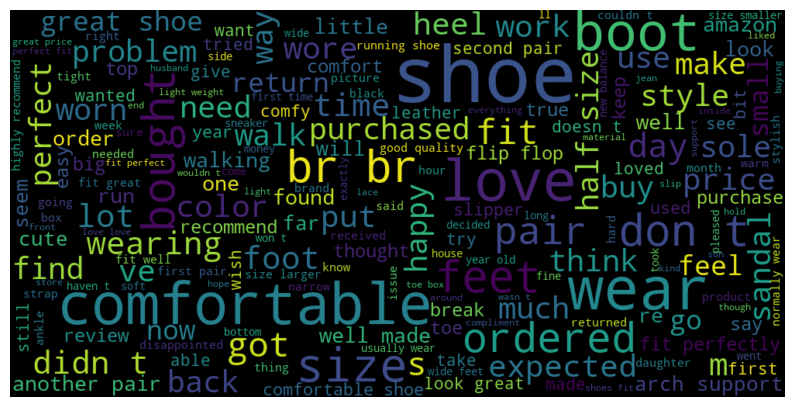

In [62]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [65]:
wordcloud.words_

{'shoe': 1.0,
 'wear': 0.52051060879977,
 'love': 0.48628851524067224,
 'comfortable': 0.48031355728594327,
 'boot': 0.40347607062817803,
 'size': 0.30376674425840805,
 'bought': 0.287083535190021,
 'feet': 0.28024305514527775,
 'br br': 0.2799397777804036,
 'don t': 0.27501742860181255,
 'ordered': 0.24565368088131614,
 'pair': 0.22174794106178586,
 'fit': 0.1744859054798675,
 'got': 0.17381140874305318,
 'day': 0.16148239612750254,
 's': 0.15913593521680394,
 'time': 0.14268806150622507,
 'm': 0.1402244252500069,
 'wearing': 0.1394396458350565,
 'lot': 0.13719263626803418,
 'didn t': 0.13594506347161994,
 'foot': 0.13420712662420783,
 'color': 0.125690743738504,
 'expected': 0.12382381554434348,
 'work': 0.12171859799206752,
 've': 0.11913680172356071,
 'wore': 0.11736341687246202,
 'heel': 0.1170089368355961,
 'price': 0.1163088387627859,
 'put': 0.11527296932172214,
 'sandal': 0.11308503976084414,
 'way': 0.1082631265926985,
 'think': 0.10734344783038524,
 'back': 0.105490304970991

In [36]:
df['verified_purchase'].value_counts()

Y    3476269
N     369804
Name: verified_purchase, dtype: int64

`verified_purchase` should be converted from Y and N to 1 and 0.

In [196]:
df['verified_purchase'] = np.where(df['verified_purchase']=='Y',1, 0)

C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\3618423303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_purchase'] = np.where(df['verified_purchase']=='Y',1, 0)


In [197]:
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,1,,do not buy really didn t start to wear them u...,2015-08-31
1,Teva Men's Pajaro Flip-Flop,5,0,0,1,super flip flop,provides great cushion as well as archsupport,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,1,badass,getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,1,three stars,small,2015-08-31
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,1,five stars,my 13 year old son loved these shoes excellent...,2015-08-31
...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,0,what a waste,i purchased this shoe because it looked good ...,2002-10-30
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,0,you want it you need it,this little shoe boot is so great if you re th...,2002-10-16
4358812,Women's CanvasMule Shoes,5,0,0,0,cute,the backless mule is very comfortable cute ...,2002-09-02
4358813,Birki's Super Birki Unisex Clog,5,10,11,0,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002-03-24


In [35]:
df['star_rating'].value_counts()

5    2313224
4     763602
3     360091
2     214971
1     194185
Name: star_rating, dtype: int64

Since there is a class imbalance it might be better to group all reviews that aren't 5 stars together and compare with 5 star reviews. After running through this 2 class model, a 5 class classification could be done through downsampling. 

In [36]:
# df2 will be the dataframe with 2 classes instead of 5 
df2 = df.copy()

In [37]:
import numpy as np
df2['star_rating'] = np.where(df['star_rating'] < 5, 0, 1)

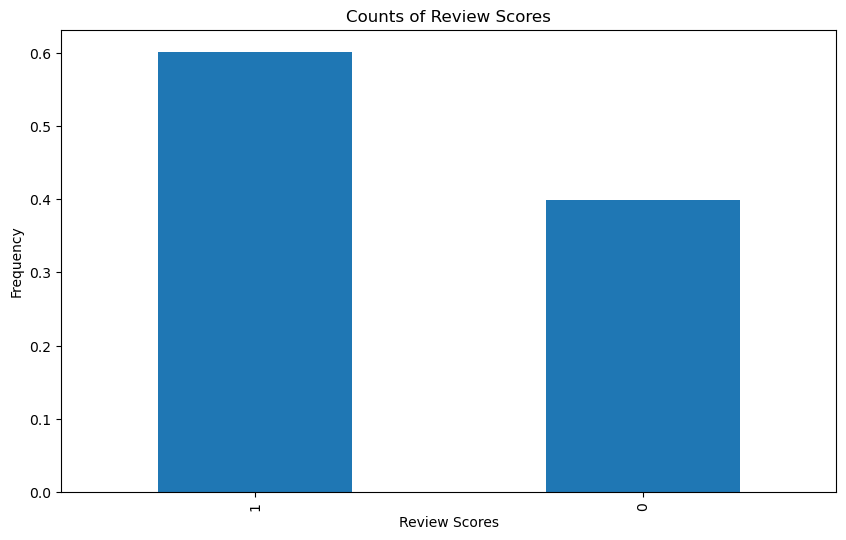

In [38]:
figure = plt.figure(figsize=(10,6))
df2['star_rating'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.title('Counts of Review Scores')
plt.show()

Still a class imbalance of 60% to 40% which should be a decent split but could be an issue if measures aren't approriately taken (stratisfy when splitting)

In [195]:
df2

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Minnetonka Men's Double Deerskin Softsole Mocc...,0,0,0,Y,,do not buy really didn t start to wear them u...,2015-08-31
1,Teva Men's Pajaro Flip-Flop,1,0,0,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
3,adidas Men's 10K Lifestyle Runner Sneaker,1,0,6,Y,badass,getting what u see,2015-08-31
4,OverBling Sneakers for Men Casual Men Shoes Ge...,0,0,0,Y,three stars,small,2015-08-31
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),1,1,1,Y,five stars,my 13 year old son loved these shoes excellent...,2015-08-31
...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,0,0,0,N,what a waste,i purchased this shoe because it looked good ...,2002-10-30
4358811,Women's Bree Suede Moc Snow Joggers,1,1,1,N,you want it you need it,this little shoe boot is so great if you re th...,2002-10-16
4358812,Women's CanvasMule Shoes,1,0,0,N,cute,the backless mule is very comfortable cute ...,2002-09-02
4358813,Birki's Super Birki Unisex Clog,1,10,11,N,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002-03-24


In [107]:
# import the library needed to split
from sklearn.model_selection import train_test_split

# assigning Reviewer_Score as target variable and everything else as X 
X = df2.drop(columns=['star_rating'])
y = df2['star_rating']

# splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [108]:
X_train_review = X_train['review_body']
X_test_review = X_test['review_body']

In [109]:
# importing the count vectorizer function
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [110]:
%%time
# Instantiate
stemmer = PorterStemmer()

bag = CountVectorizer(stop_words="english", tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], min_df=1000)

# Fitting 
bag.fit(X_train_review)

# Transform
train_bag = bag.transform(X_train_review)
test_bag = bag.transform(X_test_review)

B:\Programs\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
B:\Programs\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'th

CPU times: total: 1h 18min 59s
Wall time: 1h 19min 2s


In [46]:
train_bag

<3076858x2761 sparse matrix of type '<class 'numpy.int64'>'
	with 54892133 stored elements in Compressed Sparse Row format>

In [47]:
# importing library to deal with sparse matrix
import scipy.sparse as sp

y_sparse = sp.csr_matrix(y_train)
matrix = sp.hstack([train_bag,y_sparse.T])

In [48]:
vocab = bag.get_feature_names_out()

In [49]:
vocab[0:500]

array(['', '0', '00', '1', '10', '100', '10m', '11', '12', '120', '13',
       '14', '15', '150', '16', '17', '18', '19', '1st', '2', '20', '200',
       '2000', '2011', '2012', '2013', '2014', '2015', '21', '22', '23',
       '24', '25', '250', '26', '27', '29', '2e', '2nd', '3', '30', '300',
       '34', '35', '36', '37', '38', '39', '3e', '3rd', '4', '40', '400',
       '41', '42', '43', '44', '45', '4e', '4th', '5', '50', '500', '55',
       '5k', '5m', '5s', '5th', '5w', '6', '60', '61', '62', '65', '6th',
       '7', '70', '71', '75', '7m', '8', '80', '81', '8m', '9', '90',
       '91', '95', '99', '9m', '9w', 'abil', 'abl', 'abov', 'absolut',
       'absorb', 'absorpt', 'abus', 'accent', 'accept', 'access',
       'accessori', 'accid', 'accident', 'accommod', 'accomod', 'accord',
       'accordingli', 'account', 'accur', 'accustom', 'ach', 'achil',
       'acorn', 'act', 'action', 'activ', 'actual', 'ad', 'adapt', 'add',
       'addict', 'addit', 'address', 'adequ', 'adhes', 'ad

In [111]:
%%time
# Instantiate

bag2 = CountVectorizer(stop_words="english", tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], min_df=0.005)

# Fitting 
bag2.fit(X_train_review)

# Transform
train_bag2 = bag2.transform(X_train_review)
test_bag2 = bag2.transform(X_test_review)

CPU times: total: 1h 18min 29s
Wall time: 1h 18min 30s


In [112]:
%%time
# Instantiate

bag3= CountVectorizer(stop_words="english", tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], min_df=0.01)

# Fitting 
bag3.fit(X_train_review)

# Transform
train_bag.]3 = bag3.transform(X_train_review)
test_bag3 = bag3.transform(X_test_review)

NameError: name 'bag3fit' is not defined

In [113]:
%%time
# Instantiate
bag4 = CountVectorizer(stop_words="english", tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], min_df=1000)

# Fitting 
bag4.fit(X_train_review)

# Transform
train_bag4 = bag4.transform(X_train_review)
test_bag4 = bag4.transform(X_test_review)

CPU times: total: 1h 18min 20s
Wall time: 1h 18min 22s


In [114]:
%%time
# Instantiate
bag5 = CountVectorizer(stop_words="english", tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], min_df=2000)

# Fitting 
bag5.fit(X_train_review)

# Transform
train_bag5 = bag5.transform(X_train_review)
test_bag5 = bag5.transform(X_test_review)

CPU times: total: 1h 17min 19s
Wall time: 1h 17min 19s


In [115]:
%%time
# Instantiate
bag6 = CountVectorizer(stop_words="english", tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], min_df=4000)

# Fitting 
bag6.fit(X_train_review)

# Transform
train_bag6 = bag6.transform(X_train_review)
test_bag6 = bag6.transform(X_test_review)

CPU times: total: 1h 17min 13s
Wall time: 1h 17min 15s


In [116]:
%%time
# Instantiate
bag7 = CountVectorizer(stop_words="english", min_df=1000)

# Fitting 
bag7.fit(X_train_review)

# Transform
train_bag7 = bag7.transform(X_train_review)
test_bag7 = bag7.transform(X_test_review)

CPU times: total: 2min 50s
Wall time: 2min 50s


In [46]:
train_bag

<3076858x2761 sparse matrix of type '<class 'numpy.int64'>'
	with 54892133 stored elements in Compressed Sparse Row format>

In [47]:
# importing library to deal with sparse matrix
import scipy.sparse as sp

y_sparse = sp.csr_matrix(y_train)
matrix = sp.hstack([train_bag,y_sparse.T])

In [48]:
vocab = bag.get_feature_names_out()

In [49]:
vocab[0:500]

array(['', '0', '00', '1', '10', '100', '10m', '11', '12', '120', '13',
       '14', '15', '150', '16', '17', '18', '19', '1st', '2', '20', '200',
       '2000', '2011', '2012', '2013', '2014', '2015', '21', '22', '23',
       '24', '25', '250', '26', '27', '29', '2e', '2nd', '3', '30', '300',
       '34', '35', '36', '37', '38', '39', '3e', '3rd', '4', '40', '400',
       '41', '42', '43', '44', '45', '4e', '4th', '5', '50', '500', '55',
       '5k', '5m', '5s', '5th', '5w', '6', '60', '61', '62', '65', '6th',
       '7', '70', '71', '75', '7m', '8', '80', '81', '8m', '9', '90',
       '91', '95', '99', '9m', '9w', 'abil', 'abl', 'abov', 'absolut',
       'absorb', 'absorpt', 'abus', 'accent', 'accept', 'access',
       'accessori', 'accid', 'accident', 'accommod', 'accomod', 'accord',
       'accordingli', 'account', 'accur', 'accustom', 'ach', 'achil',
       'acorn', 'act', 'action', 'activ', 'actual', 'ad', 'adapt', 'add',
       'addict', 'addit', 'address', 'adequ', 'adhes', 'ad

In [105]:
%%time
# Instantiate
stemmer = PorterStemmer()

bag = CountVectorizer(stop_words="english", min_df=0.005)

# Fitting 
bag.fit(X_train_review)

# Transform
train_bag = bag.transform(X_train_review)
test_bag = bag.transform(X_test_review)

CPU times: total: 3min 7s
Wall time: 3min 22s


In [106]:
train_bag

<3076858x512 sparse matrix of type '<class 'numpy.int64'>'
	with 35347378 stored elements in Compressed Sparse Row format>

In [53]:
# importing library to deal with sparse matrix
import scipy.sparse as sp

y_sparse = sp.csr_matrix(y_train)
matrix = sp.hstack([train_bag,y_sparse.T])

In [54]:
vocab = bag.get_feature_names_out()

In [55]:
vocab[0:500]

array(['00', '10', '100', '10m', '10s', '11', '12', '120', '13', '14',
       '15', '150', '16', '17', '18', '19', '1st', '20', '200', '2000',
       '2011', '2012', '2013', '2014', '2015', '21', '22', '23', '24',
       '25', '250', '26', '27', '29', '2e', '2nd', '30', '300', '34',
       '35', '36', '37', '38', '39', '3e', '3rd', '40', '400', '41', '42',
       '43', '44', '45', '4e', '4th', '50', '500', '55', '5k', '5m', '5s',
       '5th', '5w', '60', '61', '62', '65', '6th', '70', '71', '75', '7m',
       '80', '81', '8m', '90', '91', '95', '99', '9m', '9w', 'ability',
       'able', 'absolute', 'absolutely', 'absorb', 'absorption', 'abuse',
       'accent', 'accents', 'accept', 'acceptable', 'access', 'accident',
       'accidentally', 'accommodate', 'according', 'accordingly',
       'account', 'accurate', 'accustomed', 'ache', 'aches', 'achilles',
       'aching', 'acorn', 'active', 'activities', 'activity', 'actual',
       'actually', 'ad', 'add', 'added', 'adding', 'addition

In [88]:
word_counts = pd.DataFrame(
    {"counts": train_bag[0:1000].toarray().sum(axis=0)},
    index=bag.get_feature_names_out()
).sort_values("counts", ascending=False)

In [90]:
train_bag[0:1000].toarray().sum(axis=0)

array([ 2, 19,  2, ...,  0,  2,  5], dtype=int64)

In [92]:
train_bag.sum(axis=0)

matrix([[ 10780, 127975,  16725, ...,   1757,   5358,   5924]],
       dtype=int64)

In [84]:
word_counts

,counts
shoes,47
great,32
comfortable,30
br,30
pair,25
...,...
grows,0
gt,0
guarantee,0
guard,0


In [178]:
bag2.get_feature_names_out()

array(['', '1', '10', '100', '11', '12', '13', '15', '2', '20', '3', '34',
       '4', '5', '6', '7', '8', '9', 'abl', 'absolut', 'actual', 'ad',
       'add', 'adjust', 'ador', 'ago', 'air', 'allow', 'alreadi', 'alway',
       'amaz', 'amazon', 'ani', 'ankl', 'anoth', 'anyon', 'anyth',
       'apart', 'appear', 'arch', 'area', 'aren', 'arriv', 'asic', 'ask',
       'attract', 'avail', 'away', 'awesom', 'bad', 'bag', 'balanc',
       'ball', 'bare', 'base', 'beat', 'beauti', 'becaus', 'becom', 'bed',
       'befor', 'believ', 'best', 'better', 'big', 'bigger', 'bit',
       'black', 'blister', 'blue', 'boot', 'bought', 'box', 'br', 'brand',
       'break', 'bright', 'broke', 'broken', 'brown', 'buy', 'calf',
       'calv', 'came', 'care', 'case', 'casual', 'caus', 'chanc', 'chang',
       'cheap', 'cheaper', 'choic', 'christma', 'clark', 'classic',
       'clean', 'close', 'cloth', 'cold', 'color', 'come', 'comfi',
       'comfort', 'comment', 'compani', 'compar', 'complaint', 'complet

In [188]:
bag4.get_feature_names_out()[100:500]

array(['access', 'accessori', 'accid', 'accident', 'accommod', 'accomod',
       'accord', 'accordingli', 'account', 'accur', 'accustom', 'ach',
       'achil', 'acorn', 'act', 'action', 'activ', 'actual', 'ad',
       'adapt', 'add', 'addict', 'addit', 'address', 'adequ', 'adhes',
       'adida', 'adjust', 'admir', 'admit', 'ador', 'adult', 'advantag',
       'adventur', 'advertis', 'advic', 'advis', 'aerob', 'aerosol',
       'aesthet', 'affect', 'afford', 'afraid', 'afternoon', 'afterward',
       'age', 'aggress', 'ago', 'agre', 'ahead', 'aid', 'air', 'airi',
       'airport', 'al', 'ala', 'alaska', 'aldo', 'alegria', 'align',
       'alittl', 'allen', 'allevi', 'allow', 'alon', 'alot', 'alreadi',
       'alright', 'altern', 'altra', 'alway', 'amaz', 'amazingli',
       'amazon', 'america', 'american', 'ampl', 'angl', 'ani', 'anim',
       'ankl', 'ann', 'annoy', 'anoth', 'answer', 'anti', 'anticip',
       'anybodi', 'anymor', 'anyon', 'anyth', 'anytim', 'anywher',
       'apart',

In [189]:
bag5.get_feature_names_out()[100:600]

array(['air', 'airport', 'allow', 'alon', 'alot', 'alreadi', 'altern',
       'alway', 'amaz', 'amazingli', 'amazon', 'american', 'angl', 'ani',
       'anim', 'ankl', 'annoy', 'anoth', 'answer', 'anticip', 'anymor',
       'anyon', 'anyth', 'anywher', 'apart', 'appar', 'appeal', 'appear',
       'appli', 'appreci', 'appropri', 'arch', 'area', 'aren', 'ariat',
       'arriv', 'arthriti', 'asic', 'asid', 'asin', 'ask', 'aspect',
       'assum', 'athlet', 'attach', 'attempt', 'attent', 'attir',
       'attract', 'australia', 'authent', 'avail', 'averag', 'avoid',
       'aw', 'awar', 'away', 'awesom', 'awhil', 'awkward', 'b', 'babi',
       'backpack', 'bad', 'badli', 'bag', 'balanc', 'ball', 'ballet',
       'band', 'bar', 'bare', 'barefoot', 'bargain', 'base', 'basi',
       'basic', 'basketbal', 'bc', 'beach', 'bear', 'bearpaw', 'beat',
       'beauti', 'becam', 'becaus', 'becom', 'bed', 'befor', 'began',
       'begin', 'beig', 'believ', 'belt', 'bend', 'benefit', 'besid',
       'be

In [190]:
bag6.get_feature_names_out()[100:600]

array(['averag', 'avoid', 'aw', 'awar', 'away', 'awesom', 'awhil',
       'awkward', 'b', 'babi', 'backpack', 'bad', 'bag', 'balanc', 'ball',
       'ballet', 'band', 'bare', 'barefoot', 'bargain', 'base', 'basic',
       'beach', 'beat', 'beauti', 'becam', 'becaus', 'becom', 'bed',
       'befor', 'began', 'begin', 'beig', 'believ', 'bend', 'besid',
       'best', 'better', 'bewar', 'big', 'bigger', 'bike', 'birkenstock',
       'birthday', 'bit', 'black', 'blister', 'blue', 'boat', 'bodi',
       'bone', 'bonu', 'boot', 'booti', 'bother', 'bought', 'bow', 'box',
       'boy', 'boyfriend', 'br', 'brand', 'break', 'breath', 'breathabl',
       'bright', 'bring', 'broke', 'broken', 'brook', 'brother',
       'brought', 'brown', 'buck', 'buckl', 'build', 'built', 'bulki',
       'bunch', 'bunion', 'busi', 'button', 'buy', 'buyer', 'c', 'calf',
       'calv', 'came', 'camp', 'canva', 'car', 'card', 'care', 'carpet',
       'carri', 'case', 'casual', 'catch', 'caus', 'certain', 'certainli'

In [192]:
bag7.get_feature_names_out()[200:800]

array(['apply', 'appreciate', 'appreciated', 'appropriate',
       'approximately', 'april', 'aqua', 'arch', 'arches', 'area',
       'areas', 'aren', 'arent', 'ariat', 'arizona', 'arm', 'army',
       'arrival', 'arrive', 'arrived', 'arthritic', 'arthritis', 'asap',
       'asics', 'aside', 'asin', 'ask', 'asked', 'asking', 'aspect',
       'asphalt', 'assume', 'assumed', 'assuming', 'ate', 'athletic',
       'attach', 'attached', 'attempt', 'attention', 'attire',
       'attractive', 'august', 'australia', 'authentic', 'available',
       'average', 'avid', 'avoid', 'aware', 'away', 'awesome', 'awful',
       'awhile', 'awkward', 'awsome', 'babies', 'baby', 'backpack',
       'backpacking', 'backs', 'backup', 'bad', 'badly', 'bag', 'baggy',
       'bags', 'balance', 'balanced', 'ball', 'ballet', 'balls', 'band',
       'bands', 'bank', 'bar', 'bare', 'barefoot', 'barely', 'bargain',
       'barn', 'base', 'baseball', 'based', 'basic', 'basically', 'basis',
       'basketball', 'bass'

In [103]:
train_bag[0:100].sum(axis=0)

matrix([[0, 1, 0, ..., 0, 0, 2]], dtype=int64)

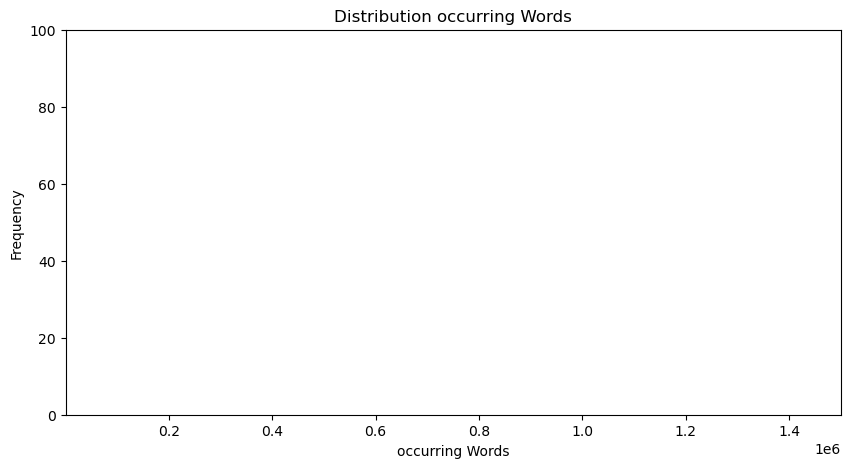

In [104]:
plt.figure(figsize=(10,5))
plt.hist(train_bag[0:100].sum(axis=0), bins=20)
plt.title("Distribution occurring Words")
plt.xlim(1000, 1500000)
plt.ylim(0, 100)
plt.xlabel("occurring Words")
plt.ylabel("Frequency")
plt.show()

In [380]:
sampled_df = df2.sample(50000, random_state=1).reset_index(drop=True)

In [381]:
sampled_df['verified_purchase'] = np.where(sampled_df['verified_purchase'] == 'Y', 1, 0)
sampled_df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
0,Kickers Men's Jojo Lace-Up Sneaker,1,0,0,1,amazing and so nice one i like kickers but thi...,amazing and so nice one br i like kickers bu...,2014-08-30
1,Madden Men's M-Gamer Boat Shoe,0,1,1,1,nice shoes,i always buy steve madden always fits perfect...,2013-10-30
2,Teva Women's Kiru Outdoor Clog,1,0,0,1,my favorite shoes,i love the deep moss green color as it matches...,2014-01-20
3,Lamo Men's Moc Moccasin,0,10,10,1,quality not so sure,at first they were great comfortable soft k...,2011-03-05
4,ECCO Men's Track IV Top Stitch High (Rust Leat...,1,0,0,1,outstanding,very comfortable right out of the box good s...,2008-10-01
...,...,...,...,...,...,...,...,...
49995,Easy Spirit Women's Traveltime Mule,1,4,5,0,easy spirit mule,love my easy spirit mules so comfortable and ...,2011-09-25
49996,"Women's Clarks, Pause Majesty Ankle Boot",0,2,2,1,color lies,this is not the color that i received the col...,2014-08-20
49997,adidas Men's Kanadia Trail 2 Trail Running Shoe,0,1,2,1,great shoes but not as good as the 1st gen ka...,i love the kanadias by adidas i have owned th...,2010-07-14
49998,Vasque Women's Inhaler Hiking Boot,1,2,2,1,great boots but order a half size up,had to exchange for a half size up from my usu...,2015-07-12


In [382]:
sampled_df['review_date'] = sampled_df['review_date'].astype('datetime64')

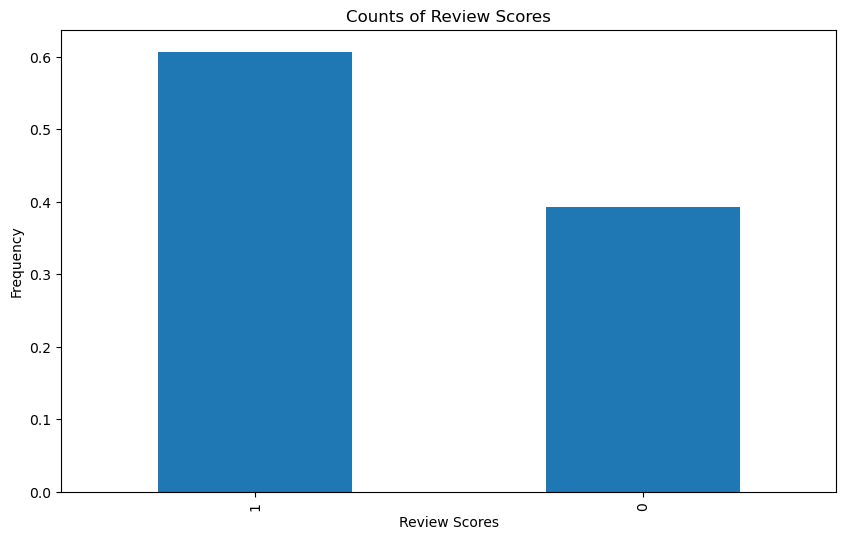

In [383]:
figure = plt.figure(figsize=(10,6))
sampled_df['star_rating'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.title('Counts of Review Scores')
plt.show()

After sampling, the classes are the same still.

In [384]:
# import the library needed to split
from sklearn.model_selection import train_test_split

# assigning Reviewer_Score as target variable and everything else as X 
X_sample = sampled_df.drop(columns=['star_rating'])
y_sample = sampled_df['star_rating']

# splitting the data 
X_sample_remainder, X_sample_test, y_sample_remainder, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=1, stratify=y_sample)

In [385]:
# Creating a validation set
X_sample_train, X_sample_valid, y_sample_train, y_sample_valid = train_test_split(X_sample_remainder, y_sample_remainder, test_size=0.3, random_state=1, stratify=y_sample_remainder)

In [387]:
sampled_df = sampled_df.drop(columns=['product_title', 'review_headline', 'review_body'])

In [386]:
X_train_review_sample = X_sample_train['review_body']
X_valid_review_sample = X_sample_valid['review_body']
X_test_review_sample = X_sample_test['review_body']

In [388]:
%%time
# Instantiate
stemmer = PorterStemmer()

bag_body = CountVectorizer(stop_words="english", min_df=250)

# Fitting 
bag_body.fit(X_train_review_sample)

# Transform
train_sample_bag = bag_body.transform(X_train_review_sample)
valid_sample_bag = bag_body.transform(X_valid_review_sample)
test_sample_bag = bag_body.transform(X_test_review_sample)

CPU times: total: 1.94 s
Wall time: 2.05 s


In [389]:
train_sample_bag

<28000x319 sparse matrix of type '<class 'numpy.int64'>'
	with 285247 stored elements in Compressed Sparse Row format>

In [390]:
X_train_headline_sample = X_sample_train['review_headline']
X_valid_headline_sample = X_sample_valid['review_headline']
X_test_headline_sample = X_sample_test['review_headline']

In [391]:
%%time
# Instantiate
stemmer = PorterStemmer()

bag_headline = CountVectorizer(stop_words="english", min_df=50)

# Fitting 
bag_headline.fit(X_train_headline_sample)

# Transform
train_sample_headline = bag_headline.transform(X_train_headline_sample)
valid_sample_headline = bag_headline.transform(X_valid_headline_sample)
test_sample_headline = bag_headline.transform(X_test_headline_sample)

CPU times: total: 422 ms
Wall time: 416 ms


In [392]:
bag_sample.get_feature_names_out()

array(['00', '10', '100', ..., 'zipper', 'zippers', 'zumba'], dtype=object)

In [393]:
# importing library to deal with sparse matrix
import scipy.sparse as sp

# combining headline and bag counts
train_count = sp.hstack([train_sample_headline, train_sample_bag])
valid_count = sp.hstack([valid_sample_headline, valid_sample_bag])
test_count = sp.hstack([test_sample_headline, test_sample_bag])

In [394]:
train_count

<28000x490 sparse matrix of type '<class 'numpy.int64'>'
	with 331790 stored elements in Compressed Sparse Row format>

In [395]:
body_words = bag_body.get_feature_names_out()
tagged_body_words = ['b_' + feature for feature in body_words]
headline_words = bag_headline.get_feature_names_out()
tagged_headline_words = ['h_' + feature for feature in headline_words]
sample_vocab = tagged_headline_words + tagged_body_words

In [396]:
len(sample_vocab)

490

In [397]:
train_count

<28000x490 sparse matrix of type '<class 'numpy.int64'>'
	with 331790 stored elements in Compressed Sparse Row format>

In [398]:
train_df = pd.DataFrame(train_count.toarray(), columns=sample_vocab)
valid_df = pd.DataFrame(valid_count.toarray(), columns=sample_vocab)
test_df = pd.DataFrame(test_count.toarray(), columns=sample_vocab)

In [433]:
X_sample_train = X_sample_train.reset_index(drop=True).drop(columns=['product_title', 'review_headline', 'review_body'])
X_sample_valid = X_sample_valid.reset_index(drop=True).drop(columns=['product_title', 'review_headline', 'review_body'])
X_sample_test = X_sample_test.reset_index(drop=True).drop(columns=['product_title', 'review_headline', 'review_body'])

In [434]:
combined_train = pd.concat([X_sample_train, train_df], axis=1)
combined_valid = pd.concat([X_sample_valid, valid_df], axis=1)
combined_test = pd.concat([X_sample_test, test_df], axis=1)

In [440]:
combined_train

,helpful_votes,total_votes,verified_purchase,review_date,h_10,h_absolutely,h_adorable,h_amazing,h_amazon,h_arch,h_asics,h_awesome,h_bad,h_bag,h_balance,h_beautiful,h_best,h_better,h_big,h_bigger,h_bit,h_black,h_boot,h_boots,h_bought,h_box,h_brand,h_buy,h_casual,h_cheap,h_clarks,h_color,h_comfort,h_comfortable,h_comfy,h_cool,h_crocs,h_cute,h_daughter,h_day,h_design,h_did,h_didn,h_disappointed,h_does,h_don,h_durable,h_easy,h_em,h_excellent,h_expected,h_extremely,h_fantastic,h_far,h_fast,h_favorite,h_feel,h_feet,h_fine,h_fit,h_fits,h_flat,h_flip,h_flop,h_flops,h_foot,h_fun,h_gift,h_good,h_gorgeous,h_got,h_great,h_half,h_happy,h_hard,h_heel,h_high,h_husband,h_just,h_large,h_larger,h_leather,h_light,h_like,h_little,h_long,h_look,h_looking,h_looks,h_lot,h_love,h_loved,h_loves,h_men,h_money,h_narrow,h_need,h_new,h_nice,h_ok,h_okay,h_old,h_order,h_ordered,h_owned,h_pair,h_perfect,h_pleased,h_poor,h_pretty,h_price,h_product,h_purchase,h_quality,h_really,h_recommend,h_return,h_review,h_right,h_run,h_running,h_runs,h_sandal,h_sandals,h_satisfied,h_second,h_sexy,h_shoe,h_shoes,h_size,h_sizes,h_sizing,h_skechers,h_slip,h_slipper,h_slippers,h_small,h_smaller,h_sneaker,h_sneakers,h_soft,h_sole,h_son,h_star,h_stars,h_style,h_stylish,h_summer,h_super,h_support,h_tight,h_time,h_toe,h_true,h_uncomfortable,h_use,h_value,h_ve,h_walk,h_walking,h_wanted,h_warm,h_way,h_wear,h_wearing,h_wide,h_width,h_wish,h_women,h_wonderful,h_work,h_worn,h_worth,h_wrong,h_year,b_10,b_11,b_12,b_34,b_able,b_absolutely,b_actually,b_ago,b_amazing,b_amazon,b_ankle,b_apart,b_arch,b_area,b_arrived,b_away,b_awesome,b_bad,b_balance,b_beautiful,b_best,b_better,b_big,b_bigger,b_bit,b_black,b_boot,b_boots,b_bought,b_box,b_br,b_brand,b_break,b_brown,b_buy,b_buying,b_calf,b_calves,b_came,b_casual,b_cheap,b_color,b_colors,b_come,b_comfort,b_comfortable,b_comfy,b_compliments,b_cool,b_couldn,b_couple,b_crocs,b_cushion,b_cute,b_daughter,b_day,b_days,b_deal,b_decided,b_definitely,b_design,b_did,b_didn,b_different,b_disappointed,b_does,b_doesn,b_don,b_dress,b_dry,b_durable,b_easily,b_easy,b_end,b_especially,b_everyday,b_exactly,b_excellent,b_expect,b_expected,b_expensive,b_extra,b_extremely,b_fact,b_far,b_fast,b_favorite,b_feel,b_feels,b_feet,b_felt,b_fine,b_fit,b_fits,b_flat,b_flip,b_flops,b_foot,b_gave,b_getting,b_gift,b_glad,b_goes,b_going,b_good,b_got,b_great,b_half,b_happy,b_hard,b_haven,b_having,b_heavy,b_heel,b_heels,b_height,b_high,b_highly,b_hiking,b_hold,b_hope,b_hours,b_house,b_hurt,b_husband,b_inside,b_instead,b_issue,b_jeans,b_just,b_kind,b_know,b_laces,b_large,b_larger,b_leather,b_left,b_length,b_light,b_lightweight,b_like,b_liked,b_little,b_ll,b_long,b_longer,b_look,b_looked,b_looking,b_looks,b_loose,b_lot,b_lots,b_love,b_loved,b_loves,b_make,b_makes,b_material,b_maybe,b_miles,b_money,b_month,b_months,b_narrow,b_need,b_needed,b_new,b_nice,b_normal,b_normally,b_ok,b_old,b_ones,b_online,b_order,b_ordered,b_ordering,b_outside,b_overall,b_owned,b_pain,b_pair,b_pairs,b_people,b_perfect,b_perfectly,b_person,b_picture,b_pleased,b_plus,b_pretty,b_price,b_probably,b_problem,b_problems,b_product,b_purchase,b_purchased,b_quality,b_quickly,b_quite,b_read,b_real,b_really,b_received,b_recommend,b_red,b_regular,b_return,b_returned,b_returning,b_review,b_reviews,b_right,b_room,b_rubber,b_run,b_running,b_runs,b_said,b_sandal,b_sandals,b_saw,b_say,b_says,b_second,b_sent,b_shipping,b_shoe,b_shoes,b_short,b_size,b_sizes,b_sizing,b_slightly,b_slip,b_slippers,b_small,b_smaller,b_sneakers,b_snow,b_snug,b_socks,b_soft,b_sole,b_soles,b_son,b_stars,b_started,b_stay,b_stiff,b_store,b_strap,b_straps,b_stretch,b_sturdy,b_style,b_stylish,b_summer,b_super,b_support,b_sure,b_thank,b_thanks,b_thing,b_think,b_thought,b_tight,b_time,b_times,b_toe,b_toes,b_took,b_tried,b_true,b_try,b_trying,b_uncomfortable,b_unfortunately,b_use,b_used,b_usually,b_ve,b_walk,b_walking,b_want,b_wanted,b_warm,b_wasn,b_water,b_waterproof,b_way,b_wear,b_wearing,b_wears,b_weather,b_week,b_weeks,b_weight,b_went,b_wet,b_white,b_wid

C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\3925347794.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = np.triu(X_train.corr())
C:\Users\Billy\AppData\Local\Temp\ipykernel_275884\3925347794.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X.corr(), annot=True, mask=matrix, cmap='coolwarm')


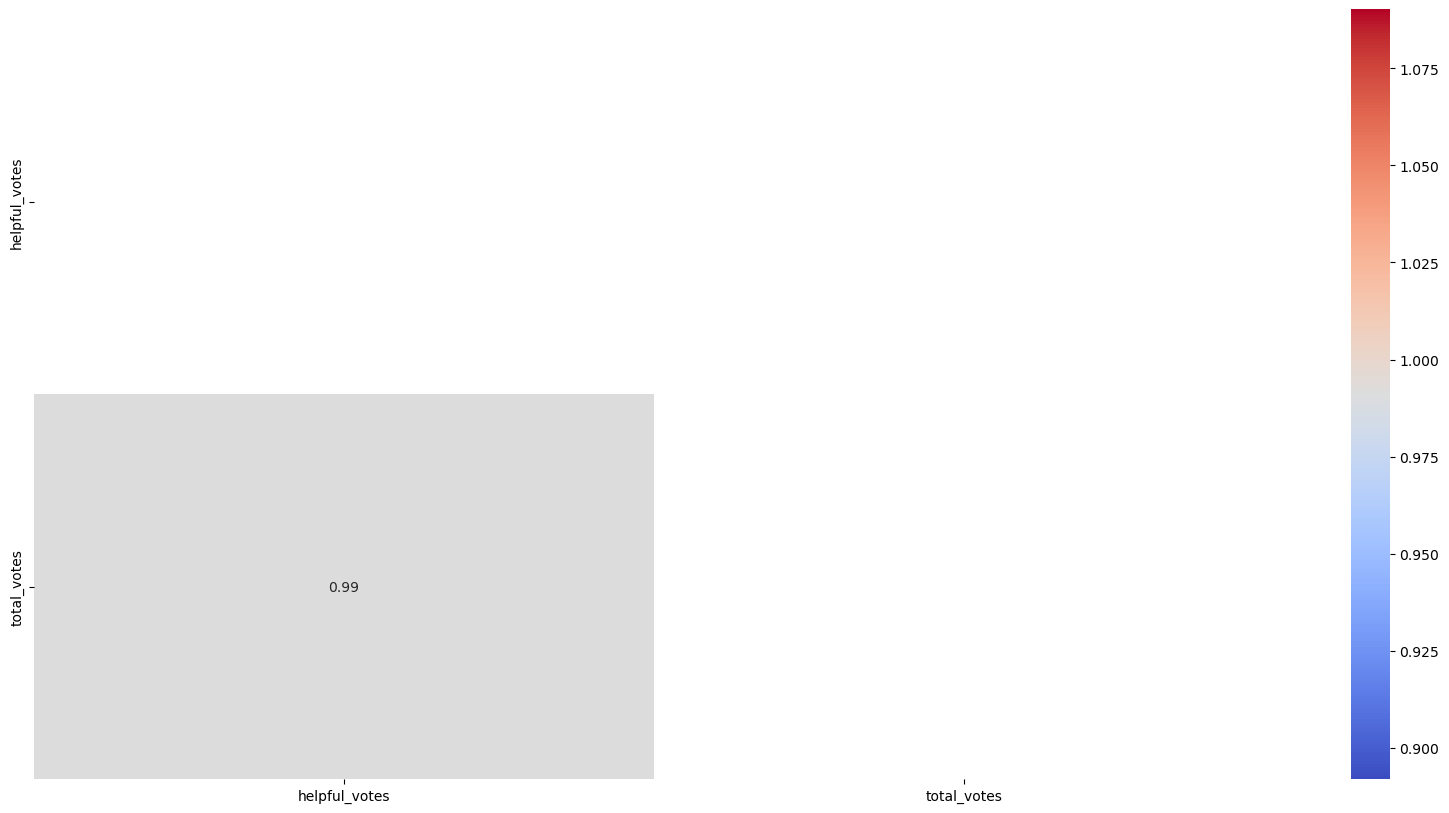

In [443]:
import seaborn as sns
# Correlation of the variables in a heatmap
plt.figure(figsize=(20, 10))
matrix = np.triu(combined_train.corr())
sns.heatmap(X.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

In [444]:
combined_train = combined_train.drop(columns=['helpful_votes', 'review_date'])
combined_valid = combined_valid.drop(columns=['helpful_votes', 'review_date']) 
combined_test = combined_test.drop(columns=['helpful_votes', 'review_date'])

In [445]:
# Scaling
from sklearn.preprocessing import StandardScaler

# Instantiate
ss = StandardScaler()

# Fit and tranform
X_train_scaled = ss.fit_transform(combined_train)
X_valid_scaled = ss.transform(combined_valid)
X_test_scaled = ss.transform(combined_test)

In [503]:
from sklearn.linear_model import LogisticRegression
# Instantiate
log = LogisticRegression(solver='lbfgs', max_iter=100000)

# Fit
log.fit(X_train_scaled, y_sample_train)

# Score
print(f'Training score: {log.score(X_train_scaled, y_sample_train)}')
print(f'Validation score: {log.score(X_valid_scaled, y_sample_valid)}')

Training score: 0.7941071428571429
Validation score: 0.7818333333333334


In [504]:
log.score(X_test_scaled, y_sample_test)

0.7791

We can try to do some hyper parameterization

In [449]:
from sklearn.linear_model import LogisticRegression
# Instantiate
log = LogisticRegression(solver='liblinear', max_iter=100000)

# Fit
log.fit(X_train_scaled, y_sample_train)

# Score
print(f'Training score: {log.score(X_train_scaled, y_sample_train)}')
print(f'Validation score: {log.score(X_valid_scaled, y_sample_valid)}')

Training score: 0.7941071428571429
Validation score: 0.7818333333333334


In [450]:
from sklearn.linear_model import LogisticRegression
# Instantiate
log = LogisticRegression(solver='saga', max_iter=100000)

# Fit
log.fit(X_train_scaled, y_sample_train)

# Score
print(f'Training score: {log.score(X_train_scaled, y_sample_train)}')
print(f'Validation score: {log.score(X_valid_scaled, y_sample_valid)}')

Training score: 0.7941071428571429
Validation score: 0.7818333333333334


In [490]:
log.score(X_test_scaled, y_sample_test)

0.7791

In [474]:
combined_train

,total_votes,verified_purchase,h_10,h_absolutely,h_adorable,h_amazing,h_amazon,h_arch,h_asics,h_awesome,h_bad,h_bag,h_balance,h_beautiful,h_best,h_better,h_big,h_bigger,h_bit,h_black,h_boot,h_boots,h_bought,h_box,h_brand,h_buy,h_casual,h_cheap,h_clarks,h_color,h_comfort,h_comfortable,h_comfy,h_cool,h_crocs,h_cute,h_daughter,h_day,h_design,h_did,h_didn,h_disappointed,h_does,h_don,h_durable,h_easy,h_em,h_excellent,h_expected,h_extremely,h_fantastic,h_far,h_fast,h_favorite,h_feel,h_feet,h_fine,h_fit,h_fits,h_flat,h_flip,h_flop,h_flops,h_foot,h_fun,h_gift,h_good,h_gorgeous,h_got,h_great,h_half,h_happy,h_hard,h_heel,h_high,h_husband,h_just,h_large,h_larger,h_leather,h_light,h_like,h_little,h_long,h_look,h_looking,h_looks,h_lot,h_love,h_loved,h_loves,h_men,h_money,h_narrow,h_need,h_new,h_nice,h_ok,h_okay,h_old,h_order,h_ordered,h_owned,h_pair,h_perfect,h_pleased,h_poor,h_pretty,h_price,h_product,h_purchase,h_quality,h_really,h_recommend,h_return,h_review,h_right,h_run,h_running,h_runs,h_sandal,h_sandals,h_satisfied,h_second,h_sexy,h_shoe,h_shoes,h_size,h_sizes,h_sizing,h_skechers,h_slip,h_slipper,h_slippers,h_small,h_smaller,h_sneaker,h_sneakers,h_soft,h_sole,h_son,h_star,h_stars,h_style,h_stylish,h_summer,h_super,h_support,h_tight,h_time,h_toe,h_true,h_uncomfortable,h_use,h_value,h_ve,h_walk,h_walking,h_wanted,h_warm,h_way,h_wear,h_wearing,h_wide,h_width,h_wish,h_women,h_wonderful,h_work,h_worn,h_worth,h_wrong,h_year,b_10,b_11,b_12,b_34,b_able,b_absolutely,b_actually,b_ago,b_amazing,b_amazon,b_ankle,b_apart,b_arch,b_area,b_arrived,b_away,b_awesome,b_bad,b_balance,b_beautiful,b_best,b_better,b_big,b_bigger,b_bit,b_black,b_boot,b_boots,b_bought,b_box,b_br,b_brand,b_break,b_brown,b_buy,b_buying,b_calf,b_calves,b_came,b_casual,b_cheap,b_color,b_colors,b_come,b_comfort,b_comfortable,b_comfy,b_compliments,b_cool,b_couldn,b_couple,b_crocs,b_cushion,b_cute,b_daughter,b_day,b_days,b_deal,b_decided,b_definitely,b_design,b_did,b_didn,b_different,b_disappointed,b_does,b_doesn,b_don,b_dress,b_dry,b_durable,b_easily,b_easy,b_end,b_especially,b_everyday,b_exactly,b_excellent,b_expect,b_expected,b_expensive,b_extra,b_extremely,b_fact,b_far,b_fast,b_favorite,b_feel,b_feels,b_feet,b_felt,b_fine,b_fit,b_fits,b_flat,b_flip,b_flops,b_foot,b_gave,b_getting,b_gift,b_glad,b_goes,b_going,b_good,b_got,b_great,b_half,b_happy,b_hard,b_haven,b_having,b_heavy,b_heel,b_heels,b_height,b_high,b_highly,b_hiking,b_hold,b_hope,b_hours,b_house,b_hurt,b_husband,b_inside,b_instead,b_issue,b_jeans,b_just,b_kind,b_know,b_laces,b_large,b_larger,b_leather,b_left,b_length,b_light,b_lightweight,b_like,b_liked,b_little,b_ll,b_long,b_longer,b_look,b_looked,b_looking,b_looks,b_loose,b_lot,b_lots,b_love,b_loved,b_loves,b_make,b_makes,b_material,b_maybe,b_miles,b_money,b_month,b_months,b_narrow,b_need,b_needed,b_new,b_nice,b_normal,b_normally,b_ok,b_old,b_ones,b_online,b_order,b_ordered,b_ordering,b_outside,b_overall,b_owned,b_pain,b_pair,b_pairs,b_people,b_perfect,b_perfectly,b_person,b_picture,b_pleased,b_plus,b_pretty,b_price,b_probably,b_problem,b_problems,b_product,b_purchase,b_purchased,b_quality,b_quickly,b_quite,b_read,b_real,b_really,b_received,b_recommend,b_red,b_regular,b_return,b_returned,b_returning,b_review,b_reviews,b_right,b_room,b_rubber,b_run,b_running,b_runs,b_said,b_sandal,b_sandals,b_saw,b_say,b_says,b_second,b_sent,b_shipping,b_shoe,b_shoes,b_short,b_size,b_sizes,b_sizing,b_slightly,b_slip,b_slippers,b_small,b_smaller,b_sneakers,b_snow,b_snug,b_socks,b_soft,b_sole,b_soles,b_son,b_stars,b_started,b_stay,b_stiff,b_store,b_strap,b_straps,b_stretch,b_sturdy,b_style,b_stylish,b_summer,b_super,b_support,b_sure,b_thank,b_thanks,b_thing,b_think,b_thought,b_tight,b_time,b_times,b_toe,b_toes,b_took,b_tried,b_true,b_try,b_trying,b_uncomfortable,b_unfortunately,b_use,b_used,b_usually,b_ve,b_walk,b_walking,b_want,b_wanted,b_warm,b_wasn,b_water,b_waterproof,b_way,b_wear,b_wearing,b_wears,b_weather,b_week,b_weeks,b_weight,b_went,b_wet,b_white,b_wide,b_wider,b_width,b_wife,b

In [467]:
len(log.coef_[1])

492

In [475]:
log.coef_[0]

array([-2.82275397e-02,  1.42302810e-02,  5.29929188e-03, -3.75813035e-02,
        2.65117588e-02,  7.81578894e-02, -3.31676594e-03, -4.08018512e-02,
        1.31621739e-02,  1.54770217e-01, -5.64771665e-02,  1.48720209e-02,
       -5.34465300e-03,  5.24131173e-02,  2.74015582e-01, -7.75342243e-03,
       -9.19275766e-02, -3.42046511e-02, -3.07820947e-02, -2.68451391e-02,
       -1.65739591e-02,  3.60933258e-02,  9.54385813e-04, -1.53209555e-02,
       -3.66056726e-02,  2.54913725e-02, -1.59764021e-03, -8.91104726e-02,
        1.28719667e-02, -6.67897880e-02,  8.43701109e-02,  1.02613731e-01,
        5.67162112e-02,  3.45427587e-02,  5.47257355e-03, -1.41729551e-02,
       -2.62775194e-02, -8.28284336e-04, -5.06738257e-02, -1.65845673e-02,
       -4.72946887e-02, -1.32531446e-01,  5.73011247e-04, -8.13170745e-02,
       -1.24154061e-02,  1.00450821e-02,  5.63711469e-02,  1.37824697e-01,
       -2.47877270e-02,  6.31356244e-03,  1.48359712e-01, -3.39911845e-02,
        1.95560320e-02,  

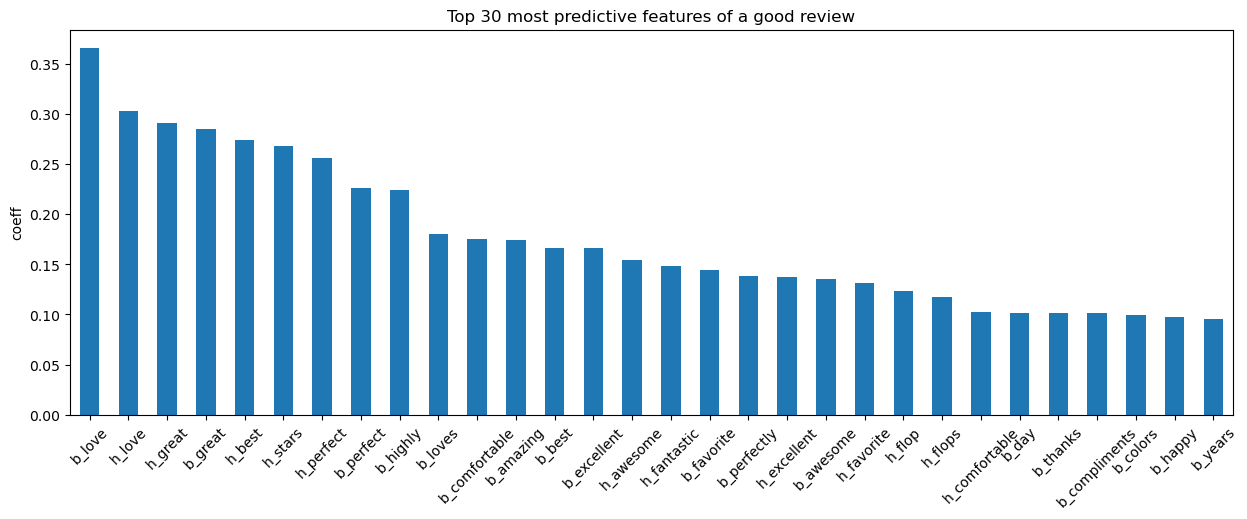

In [505]:
word_counts = pd.DataFrame({"counts":log.coef_[0]}, index=combined_train.columns).sort_values("counts", ascending=False)
word_counts.head(30).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 30 most predictive features of a good review")
plt.ylabel("coeff")
plt.xticks(rotation=45)
plt.show()

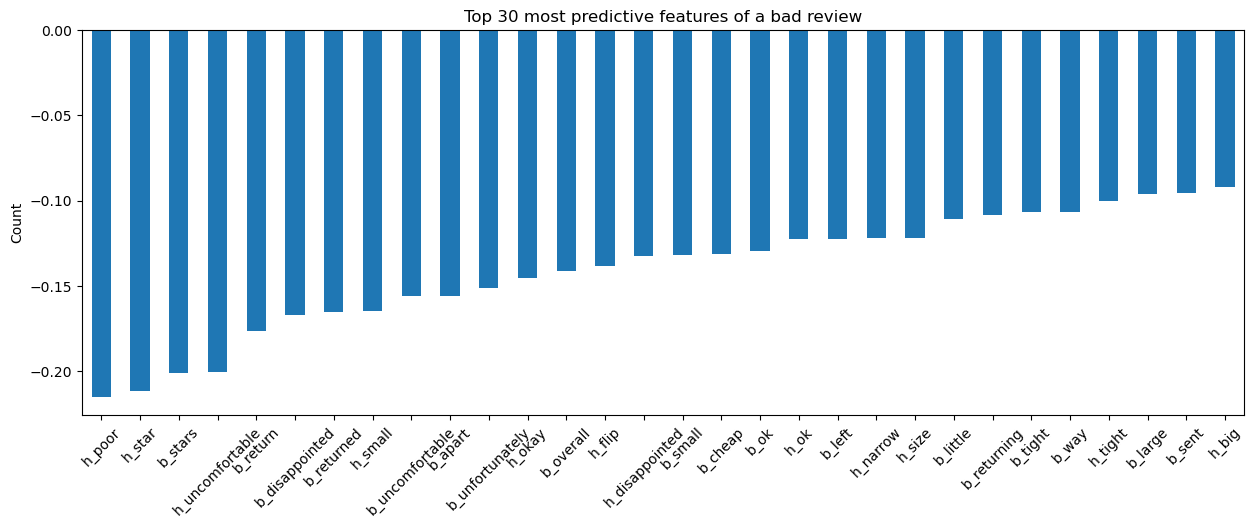

In [506]:
word_counts = pd.DataFrame({"counts":log.coef_[0]}, index=combined_train.columns).sort_values("counts", ascending=True)
word_counts.head(30).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 30 most predictive features of a bad review")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

--- 

## Method 2: embedding to filter 
Below is an attempt to filter out shoes and outliers using Hugging face embedding and clustering. (Did not have time to finetune so opt'ed to manual remove non-shoe data)

In [494]:
from sentence_transformers import SentenceTransformer

In [495]:
embedder = SentenceTransformer('bert-base-cased')

No sentence-transformers model found with name C:\Users\Billy/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Billy/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

In [496]:
product_names = df['product_title']
product_names

0          Minnetonka Men's Double Deerskin Softsole Mocc...
1                                Teva Men's Pajaro Flip-Flop
3                  adidas Men's 10K Lifestyle Runner Sneaker
4          OverBling Sneakers for Men Casual Men Shoes Ge...
5                        MESSI 15.3 FG/AG SOCCER SHOES (8.5)
                                 ...                        
4358810                       Women's Evette Mid-Shaft Boots
4358811                  Women's Bree Suede Moc Snow Joggers
4358812                             Women's CanvasMule Shoes
4358813                      Birki's Super Birki Unisex Clog
4358815                   Fox Men's Featherlite Shoe Lace-Up
Name: product_title, Length: 3846073, dtype: object

In [501]:
corpus = list(product_names)
corpus = corpus[0:50000]
corpus

TypeError: 'list' object is not callable

In [500]:
%%time
corpus_embeddings = embedder.encode(corpus)

KeyError: 31358

In [35]:
from sklearn.cluster import KMeans

In [36]:
%%time
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

NameError: name 'corpus_embeddings' is not defined

In [37]:
cluster_df = pd.DataFrame(corpus, columns = ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df

NameError: name 'cluster_assignment' is not defined

In [ ]:
common_shoes = ['running shoe', 'walking shoe', 'flip', 'sandal', 'sneaker'] #flip for flip flop

In [ ]:
label_shoes = df['product_title'].str.contains('|'.join(common_shoes), case=False, na=False)
df_shoes=df[label_shoes]

In [ ]:
test = ['flip flop']
label_test = df['product_title'].str.contains('|'.join(test), case=False, na=False)
df_test=df[label_test]

In [ ]:
df_test

In [ ]:
common_others = [' bag ', 'sunglasses', 'wallet', 'ray ban', 'rayban', 'tote', 'handbag', 'purse', 'clutch'] 

In [ ]:
label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)
df[label_others]

In [ ]:
df_shoes[label_others]

In [ ]:
# creating a dataframe with just product names
df_names = df['product_title']
df_others = pd.DataFrame(df_names[label_others]) #pd.Dataframe is needed to add the column label after
df_shoes = pd.DataFrame(df_names[label_shoes])
df_others['label'] = 'others'
df_shoes['label'] = 'shoes'

In [ ]:
# combining and removing products that have shoes and others tag
combined_df = pd.concat([df_others, df_shoes])
filtered_df = combined_df[~(label_others & label_shoes)]

In [ ]:
common_shoes = ['running shoe', 'walking shoe', 'flip', 'sandal', 'sneaker', 'boot', 'crocs', 'skateboarding shoe', 'clog', 'hiking shoe', 'slipper', 'flat', 'pump', 'shoe'] #flip for flip flop

In [ ]:
label_shoes = df['product_title'].str.contains('|'.join(common_shoes), case=False, na=False)
df_shoes=df[label_shoes]

In [ ]:
# Create a boolean mask indicating rows in df1 that are not present in df2
mask = ~df.isin(df_shoes)

# Filter df1 using the mask to get rows not in df2
result = df[mask]

In [ ]:
# Print the result

list(result.dropna()['product_title'].unique())

In [ ]:
df_shoes['product_title']

In [ ]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])
    
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
def word_cloud(pred_df, label):
    wc = ' '.join([text for text in pred_df['corpus'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width = 800, height = 500, random_state = 20, max_font_size = 110).generate(wc)
    fig7 = plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [ ]:
word_cloud(cluster_df, 0)

In [ ]:
word_cloud(cluster_df, 1)

In [ ]:
labeled_embeddings = embedder.encode(filtered_df)

In [ ]:
%%time
corpus_embeddings = embedder.encode(corpus)

In [ ]:
%%time
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [ ]:
test